# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [1]:
import helper as hlp
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

# Wnioski po zadaniu 1

Po przejrzeniu danych mogę stwierdzić że:
- kobiety miały największe prawdopodobieństwo na przeżycie
- osoby starsze miały największe prawdopodobieństwo na śmierć
- osoby młodsze miały największe prawdopodobieństwo na przeżycie
- im wyższa klasa podróży oraz majątek danej osoby tym większe prawdopodobieństwo na przeżycie
- osoby które wsiadły z portu w Queenstown miały największe prawdopodobieństwo na śmierć a najmniejsze z Southampton.
- osoby które nie miały przydzielonej kabiny miały największe prawdopodobieństwo na śmierć porównując ich do innych przedziałów

Na podstawie tych wniosków usunę kolumnę Name i Ticket, zmienię trochę spsoób obsługiwania braków wartości głównie chodzi o obsłużenie wieku oraz znormalizuje wiek oraz fare nie będę wrzucać do notatnika tego kodu będzie on w zewnętrznym pliku helper.py

# Przygotowanie danych

## Wczytanie

In [2]:
titanic_df = pd.read_csv('titanic.csv', index_col='PassengerId')

## Przetworzenie danych

In [3]:
processed_titanic_df = hlp.proces_df(titanic_df)
processed_titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Department,AgeGroup,TicketPrice
PassengerId,,,,,,,,,,,
1,0,3,1,0.271174,1,0,0.014151,0,0,2,1
2,1,1,0,0.472229,1,0,0.139136,1,1,2,2
3,1,3,0,0.321438,0,0,0.015469,0,0,2,1
4,1,1,0,0.434531,1,0,0.103644,0,1,2,2
5,0,3,1,0.434531,0,0,0.015713,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,0.334004,0,0,0.025374,0,0,2,2
888,1,1,0,0.233476,0,0,0.058556,0,2,2,2
889,0,3,0,0.264891,1,2,0.045771,0,0,2,2


## Przygotowanie zbioru treningowego i testowego

Skorzystamy z gotowego rozwiązania dzielenia

In [4]:
X = processed_titanic_df.drop(columns=['Survived']).values
y = processed_titanic_df['Survived'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
x_train

array([[3.        , 1.        , 0.30887158, ..., 0.        , 2.        ,
        2.        ],
       [2.        , 1.        , 0.37170143, ..., 0.        , 2.        ,
        0.        ],
       [1.        , 1.        , 0.49736115, ..., 1.        , 2.        ,
        3.        ],
       ...,
       [3.        , 0.        , 0.59788892, ..., 0.        , 2.        ,
        2.        ],
       [1.        , 1.        , 0.58532295, ..., 4.        , 2.        ,
        2.        ],
       [1.        , 1.        , 0.49736115, ..., 0.        , 2.        ,
        2.        ]])

In [6]:
y_train

[1, 0, 0, 1, 1, ..., 1, 1, 0, 0, 1]
Length: 712
Categories (2, int64): [0, 1]

# Analiza modeli
Spojrzę na różne modele, wybór cześći z nich może wydać się dziwaczny ale jestem ciekawy jak sobie poradzą. Z racji że będę przeprowadzać klasyfikację moim głównym narzędziem do porównywania jakości tych klasyfikacji będzie macierz pomyłek a wraz z nią jej parametry takie jak dokładność precyzja itd..

## Baseline
Skorzystamy z dummy Clasifier

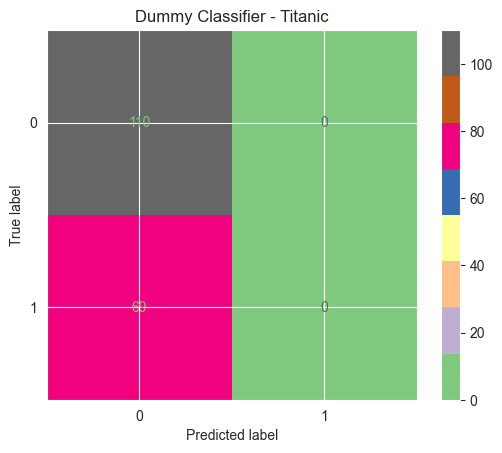

Accuracy: 0.6145251396648045

Classification Report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76       110
           1       0.00      0.00      0.00        69

    accuracy                           0.61       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.61      0.47       179



C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [7]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy.classes_)
disp.plot(cmap="Accent")
plt.title("Dummy Classifier - Titanic")
plt.show()

# Metryki macierzy pomyłek
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Jak widać model potrafi tylko zgadywać najczęstszą klasę czyli nie przeżył i radzi sobie jako tako osiągając dokładność na poziomie 60 procent co niby jest lepsze od rzutu monetą ale postaramy się zrobić lepszy model

## Klasyfikacja za pomocą PCA
Chcę sprawdzić czy dla danych jakie mamy możemy przeprowadzić redukcję wymiarowości żeby móc oddzielić dwie klasy więc skorzystamy najpierw z PCA gdzie jest ona nienadzorowana i nie bierze pod uwagi informacji o klasach a następnie LDA gdzie informację o klasie są już zawarte oczywiście te dwie metody różnią się bardziej, polecam https://www.youtube.com/watch?v=HMOI_lkzW08 - PCA
https://www.youtube.com/watch?v=azXCzI57Yfc - LDA po więcej informacji

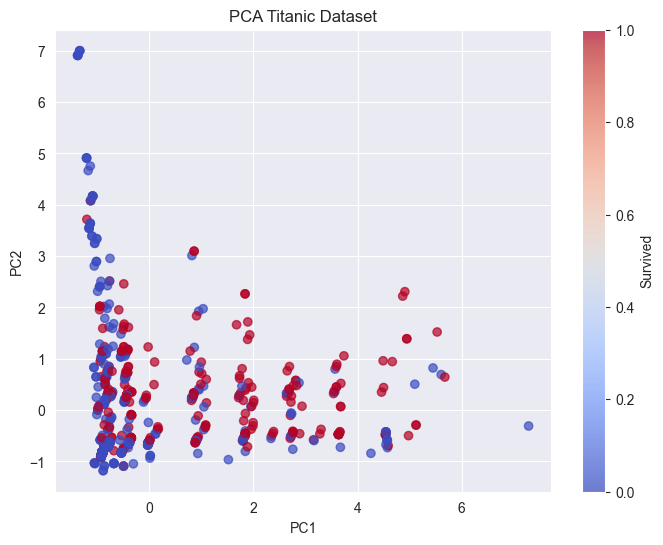

In [8]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Titanic Dataset")
plt.colorbar(scatter, label="Survived")
plt.show()

Nie będę korzystać bo po wykresie widać że nie rozdziela obu klas

## Klasyfikacja za pomocą LDA

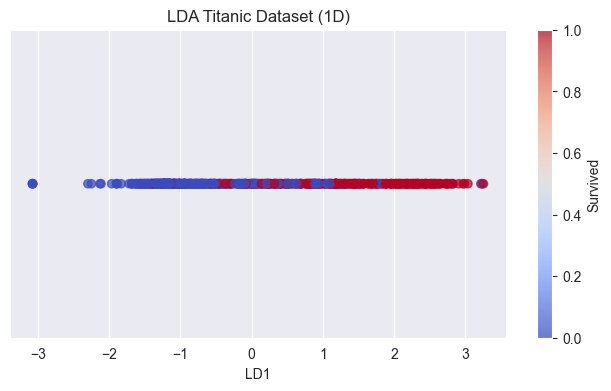

In [9]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_reduced = lda.fit_transform(X, y)

plt.figure(figsize=(8,4))
plt.scatter(X_reduced[:, 0], [0]*len(X_reduced), c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel("LD1")
plt.yticks([])
plt.title("LDA Titanic Dataset (1D)")
plt.colorbar(label="Survived")
plt.show()

Tutaj wydaje się trochę odseparowywać sprawdzę dla danych testowych i treningowych jak taki model by się sprawdził

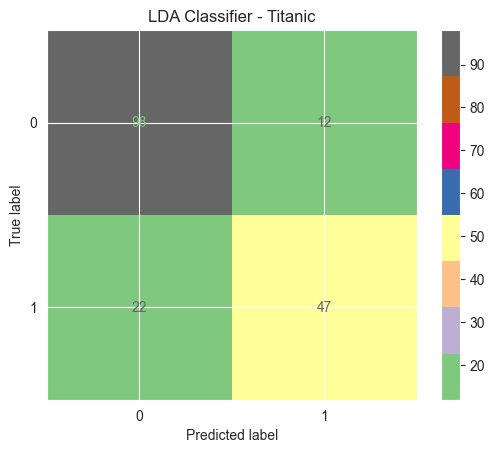

Accuracy: 0.8100558659217877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [10]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot(cmap="Accent")
plt.title("LDA Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Osiągneliśmy dokładność na poziomie 80 procent co jest niezły wynikiem ale możemy spróbować jeszcze lepiej

## Klasyfikacja za pomocą SVM

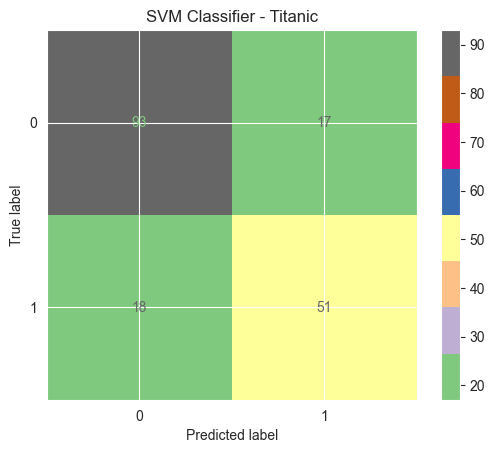

Accuracy: 0.8044692737430168

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [11]:
clf = SVC(kernel='poly')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("SVM Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Identycznie jak w przypadku LDA nie udało się osiągnąć lepszej dokładności

## Klastyfikacja za pomocą Regresji Logistycznej

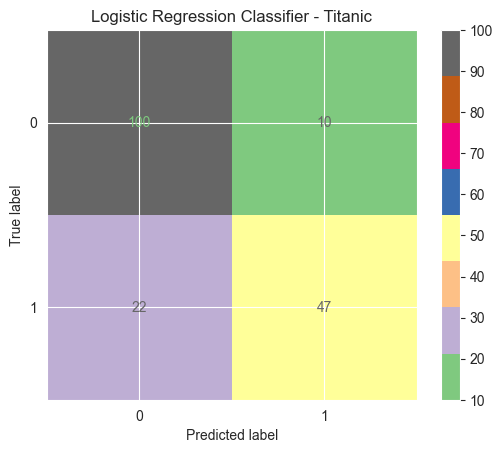

Accuracy: 0.8212290502793296

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [12]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Logistic Regression Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Regresja logistyczna poradziła sobie trochę lepiej ograniczając liczbę przypadków gdzie model błędnie stwierdzał że ktoś nie przeżyje

# Badanie Modeli
Do głębszego zbadania wybrałem LDA oraz Regresję Logistyczną

## Badanie LDA
- Parametry które będziemy sprawdzać to będą wybór solvera są 2 rodzaje "eigen", "lsqr"

### Dla eigen

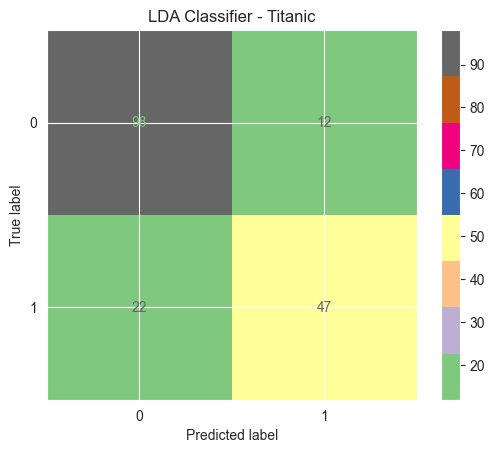

Accuracy: 0.8100558659217877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [13]:
lda = LinearDiscriminantAnalysis(n_components=1, solver='eigen')
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot(cmap="Accent")
plt.title("LDA Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Dla svd

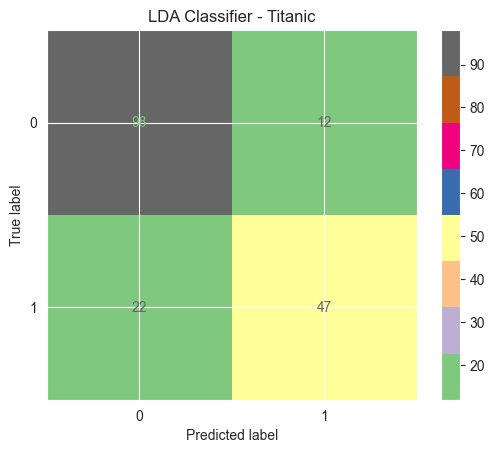

Accuracy: 0.8100558659217877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [14]:
lda = LinearDiscriminantAnalysis(n_components=1, solver='svd')
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot(cmap="Accent")
plt.title("LDA Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

## Badanie Regresja Logistyczna
Będziemy bawić się hiperparametrem penalty i solver

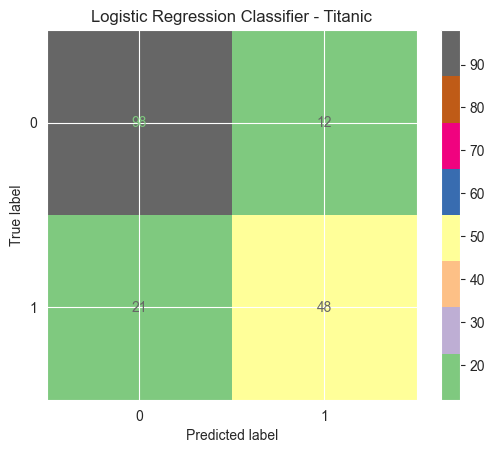

Accuracy: 0.8156424581005587

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



In [15]:
log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Logistic Regression Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

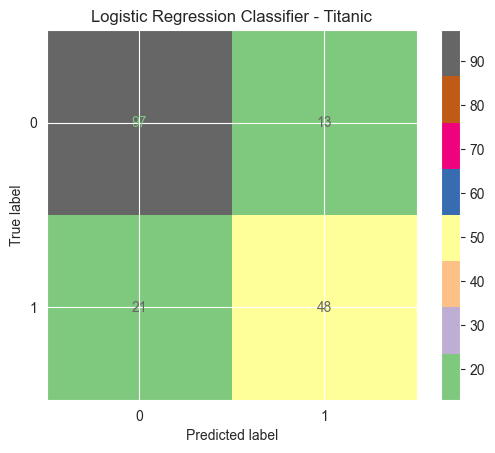

Accuracy: 0.8100558659217877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [16]:
log_reg = LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear')
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Logistic Regression Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

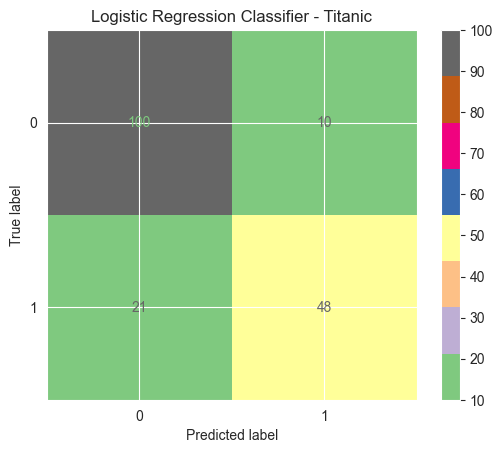

Accuracy: 0.8268156424581006

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



In [17]:
log_reg = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5)
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Logistic Regression Classifier - Titanic")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

widzimy że ta kombinacja jest najlepsza

# Wnioski

Najlepszym modelem okazała się regresja logistyczna osiągając wynik 82 procent

In [33]:
test_df = pd.DataFrame([{
    "Pclass": 3,
    "Sex": "male",
    "Age": 23,
    "SibSp": 0,
    "Parch": 0,
    "Fare": 40,
    "Embarked": 'Q',
    "AgeGroup": 3,
    "Cabin": 'B25',
    "Survived": 0,
    "Ticket": 25,
    "Name": "ja"
}])

proc = hlp.proces_df(test_df)
x = proc.drop(columns=['Survived']).values

y_pred = log_reg.predict(x)
y_pred

array([0], dtype=int64)

Według modelu nie udałoby mi się przeżyć na titanicu :(